In [113]:
from tensorflow.keras.layers import Dense , Dropout ,Input , LSTM, Activation, concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras import initializers

import librosa
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

In [114]:
names = os.listdir('train/')
#print(names)

data = []
for i in names :
    data.append(librosa.load('train/' + i))

data = np.array(data)
data.shape


(1994, 2)

<AxesSubplot:>

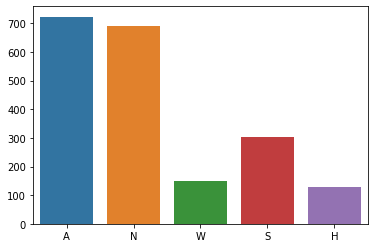

In [116]:
dictionary = { 'A' : 0, 'N' : 0, 'W' : 0, 'S' : 0, 'H' : 0}
for i in names : 
    dictionary[ i[5] ] += 1

sns.barplot(list(dictionary.keys()), list(dictionary.values()))

In [206]:
###### data aumentation : idea for time_masking augmentation has been inspired by the link below : 
###### https://towardsdatascience.com/data-augmentation-for-speech-recognition-e7c607482e78
###### the rest are just librosas effects
def AUG_time_masking(sound) :
    sound = list(sound) 

    lenght = len(sound)
    number_of_masks = 3 * lenght // 100
    frame_to_mask = random.sample(range(0, lenght), number_of_masks)

    cnt = 0
    for i in frame_to_mask : 
        del(sound[i - cnt])
        cnt += 1

    sound = np.array(sound)
    return sound
    


def AUG_time_strech(sound, strech_rate) : 
    sound = librosa.effects.time_stretch(sound, strech_rate)
    return sound


def AUG_shift_pitch(sound, sr, n_pitch) :
    sound = librosa.effects.pitch_shift(sound, sr, n_steps=n_pitch)
    return sound



In [207]:
S_class = []
H_class = []
W_class = []
aug = []

for i in range(1994) : 
    if names[i][5] == 'S' : 
         S_class.append(i)
    elif names[i][5] == 'H' : 
         H_class.append(i)
    elif names[i][5] == 'W' : 
         W_class.append(i)




extended_names = []
extended_sounds = [] 

for i in range(len(H_class)) : 
    extended_names.append( str(len(extended_names) + len(names)) + names[H_class[i]][4:])
    extended_sounds.append(AUG_time_masking(data[H_class[i]][0]))
    extended_names.append( str(len(extended_names) + len(names)) + names[H_class[i]][4:])
    extended_sounds.append(AUG_time_strech(data[H_class[i]][0], 0.5))
    extended_names.append( str(len(extended_names) + len(names)) + names[H_class[i]][4:])
    extended_sounds.append(AUG_time_strech(data[H_class[i]][0], 1.5))
    extended_names.append( str(len(extended_names) + len(names)) + names[H_class[i]][4:])
    extended_sounds.append(AUG_shift_pitch(data[H_class[i]][0], data[H_class[i]][1], 8))



for i in range(len(W_class)) : 
    extended_names.append( str(len(extended_names) + len(names)) + names[W_class[i]][4:])
    extended_sounds.append(AUG_time_masking(data[W_class[i]][0]))
    extended_names.append( str(len(extended_names) + len(names)) + names[W_class[i]][4:])
    extended_sounds.append(AUG_time_strech(data[W_class[i]][0], 0.5))
    extended_names.append( str(len(extended_names) + len(names)) + names[W_class[i]][4:])
    extended_sounds.append(AUG_time_strech(data[W_class[i]][0], 1.5))
    extended_names.append( str(len(extended_names) + len(names)) + names[W_class[i]][4:])
    extended_sounds.append(AUG_shift_pitch(data[W_class[i]][0], data[W_class[i]][1], 8))


for i in range(len(S_class)) : 
    extended_names.append( str(len(extended_names) + len(names)) + names[S_class[i]][4:])
    extended_sounds.append(AUG_shift_pitch(data[S_class[i]][0], data[S_class[i]][1], 8))


#for i in range(1994) : 
#    extended_names.append( str(len(extended_names) + len(names)) + names[i][4:])
#    extended_sounds.append(AUG_shift_pitch(data[i][0], data[i][1], 4))





In [208]:

new_names = np.concatenate([names, extended_names], axis=0)
for i in range(len(extended_sounds)) : 
    extended_sounds[i] = [extended_sounds[i], data[0][1]]

new_data = np.concatenate([data, extended_sounds], axis=0)
new_names.shape, new_data.shape

((3412,), (3412, 2))

<AxesSubplot:>

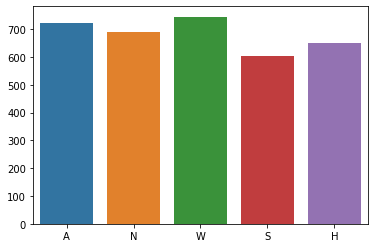

In [209]:

dictionary = { 'A' : 0, 'N' : 0, 'W' : 0, 'S' : 0, 'H' : 0}
# for i in extended_names : 
#     for x in ['H', 'A', 'N', 'W', 'S'] : 
#         if x in i :
#             dictionary[ x ] += 1
# for i in names : 
#     for x in ['H', 'A', 'N', 'W', 'S'] : 
#         if x in i :
#             dictionary[ x ] += 1
for i in range(len(new_names)) : 
    dictionary[new_names[i][5]] += 1
sns.barplot(list(dictionary.keys()), list(dictionary.values()))


In [210]:
y=[]
label_dict = {'A' : [1, 0, 0, 0, 0], 'N' : [0, 1, 0, 0, 0], 'W' : [0, 0, 1, 0, 0], 'S' : [0, 0, 0, 1, 0], 'H' : [0, 0, 0, 0, 1], }
for i in range(len(new_names)) : 
    y.append(label_dict[new_names[i][5]])    
y = np.array(y)

In [211]:
feature1 = []
for i in range(len(new_data)) : 
    mfcc = np.mean(librosa.feature.mfcc(y=new_data[i][0], sr=new_data[i][1], n_mfcc=36).T,axis=0)
    feature1.append(mfcc)


# feature2 = []
# for i in range(len(data)) : 
#    cens = np.mean(librosa.feature.chroma_cens(y=data[i][0], sr=data[i][1], n_chroma=36).T,axis=0)
#    feature2.append(cens)





In [212]:
feature1 = np.array(feature1)
feature1 = feature1.reshape((len(feature1), 36, 1))

# feature2 = np.array(feature2)
# feature2 = feature2.reshape((len(feature2), 36, 1))


# features = np.concatenate([feature1, feature2], axis=2)

In [213]:
from sklearn.utils import shuffle

feature1_sh, y_sh = shuffle(feature1, y)

In [214]:
from sklearn.model_selection import train_test_split
feature1_train, feature1_valid, y_train, y_valid = train_test_split(feature1, y, test_size=0.3, random_state=42)

Epoch 1/10
38/38 [==============================] - 4s 118ms/step - loss: 1.4530 - accuracy: 0.3819 - val_loss: 1.3432 - val_accuracy: 0.4365
Epoch 2/10
38/38 [==============================] - 3s 85ms/step - loss: 1.3146 - accuracy: 0.4527 - val_loss: 1.2566 - val_accuracy: 0.4814
Epoch 3/10
38/38 [==============================] - 3s 82ms/step - loss: 1.2348 - accuracy: 0.5117 - val_loss: 1.2237 - val_accuracy: 0.5244
Epoch 4/10
38/38 [==============================] - 3s 83ms/step - loss: 1.1921 - accuracy: 0.5318 - val_loss: 1.1871 - val_accuracy: 0.5244
Epoch 5/10
38/38 [==============================] - 3s 81ms/step - loss: 1.1287 - accuracy: 0.5557 - val_loss: 1.1465 - val_accuracy: 0.5479
Epoch 6/10
38/38 [==============================] - 3s 85ms/step - loss: 1.1122 - accuracy: 0.5741 - val_loss: 1.1440 - val_accuracy: 0.5576
Epoch 7/10
38/38 [==============================] - 3s 83ms/step - loss: 1.0857 - accuracy: 0.5875 - val_loss: 1.1205 - val_accuracy: 0.5508
Epoch 8/10
3

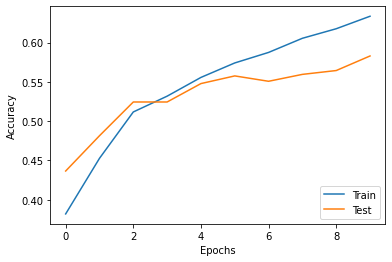

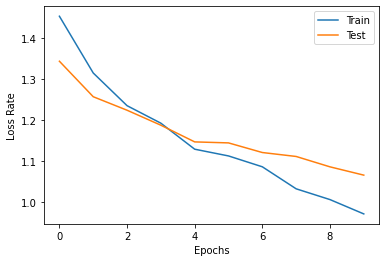

In [215]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional



model = Sequential()
model.add(Bidirectional(LSTM(36, return_sequences=True, activation='relu'), input_shape=(36, 1)))
model.add(Bidirectional(LSTM(36, activation='tanh')))
model.add(Dense(18, activation='tanh'))
model.add(Dense(12, activation='tanh'))
model.add(Dense(5, activation='softmax'))
#opt = RMSprop(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(feature1_train, y_train ,validation_data=(feature1_valid, y_valid), epochs=10, batch_size = 64 ,verbose=1)






plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc = 'lower right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss Rate')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

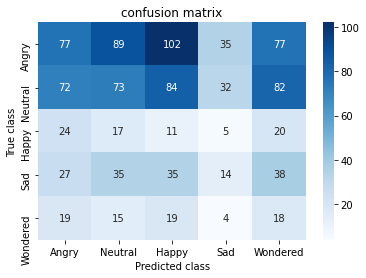

In [224]:
labels = {0 : 'Angry', 1 : 'Neutral', 2 : 'Happy', 3 : 'Sad', 4 : 'Wondered'}
def to_str(x, labels) :
    i = x.argmax()
    return labels[i]



predictions = model.predict(feature1_valid)
real = np.array(y).copy()

confusion1 = []
confusion2 = []

for i in range(len(feature1_valid)) : 
    confusion1.append(to_str(real[i], labels))
    confusion2.append(to_str(predictions[i], labels))



confusion1 = np.asarray(confusion1)
confusion2 = np.asarray(confusion2)

from sklearn.metrics import confusion_matrix

LABELS=["Angry", "Neutral", "Happy", 'Sad', 'Wondered']

conf_matrix = confusion_matrix(confusion1, confusion2, labels=LABELS)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [218]:
test_file_names = os.listdir('test/')


test_sounds = []
for i in range(len(test_file_names)) : 
    path = 'test/'+ test_file_names[i]
    test_sounds.append(librosa.load(path))


test_mfcc = []
for i in range(len(test_sounds)) : 
    mfcc = np.mean(librosa.feature.mfcc(y=test_sounds[i][0], sr=test_sounds[i][1], n_mfcc=36).T,axis=0)
    test_mfcc.append(mfcc)


test_mfcc = np.array(test_mfcc)
test_mfcc = test_mfcc.reshape((227, 36, 1))

test_pred = model.predict(test_mfcc)
test_pred

NameError: name 'extract_MFCC' is not defined

In [250]:
if (test_predictions[1] == [0., 1., 0., 0., 0.]).all() : 
    print(1)

1


In [252]:
ans = [] 
ans_dict = {}


for i in range(len(test_predictions)) : 
    if (test_predictions[i] == [1., 0., 0., 0., 0.]).all() :  
        ans.append('A') 
    elif (test_predictions[i] == [0., 1., 0., 0., 0.]).all() :  
        ans.append('N') 
    elif (test_predictions[i] == [0., 0., 1., 0., 0.]).all() :  
        ans.append('H') 
    elif (test_predictions[i] == [0., 0., 0., 1., 0.]).all() :  
        ans.append('S') 
    elif (test_predictions[i] == [0., 0., 0., 0., 1.]).all() :  
        ans.append('W') 

answer = pd.DataFrame({'id' : np.array(test_file_names), 'class' : np.array(ans)})
answer.to_csv('test_answers.csv', index=False)
